In [66]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torchsummary import summary

import os
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

In [67]:
batch_size = 64
epochs = 100
lr = 1e-3
latent_dim = 100

In [68]:
seed = 975
torch.manual_seed(seed)

In [69]:
device = torch.device("cuda")
device

device(type='cuda')

In [70]:
class CelebAHQDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.images = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.images[idx])
        try:
            image = Image.open(img_name).convert('RGB')
        except (IOError, FileNotFoundError):
            print(f'Error loading image {img_name}')
            return None

        if self.transform:
            image = self.transform(image)

        return image

    
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

dataset = CelebAHQDataset('../../data/celeba_hq_256', transform=transform)
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)

In [71]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1), # 128x128
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1), # 64x64
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), # 32x32
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1), # 16x16
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(256 * 16 * 16, latent_dim),
            nn.ReLU(),
        )

        # Latent space
        self.fc_mu = nn.Linear(latent_dim, latent_dim)
        self.fc_logvar = nn.Linear(latent_dim, latent_dim)
        self.fc_decode = nn.Linear(latent_dim, 256 * 16 * 16)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (256, 16, 16)),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1), # 32x32
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1), # 64x64
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1), # 128x128
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1), # 256x256
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.fc_decode(z)
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [72]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

In [73]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [74]:
summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]           1,568
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              ReLU-3         [-1, 32, 128, 128]               0
            Conv2d-4           [-1, 64, 64, 64]          32,832
       BatchNorm2d-5           [-1, 64, 64, 64]             128
              ReLU-6           [-1, 64, 64, 64]               0
            Conv2d-7          [-1, 128, 32, 32]         131,200
       BatchNorm2d-8          [-1, 128, 32, 32]             256
              ReLU-9          [-1, 128, 32, 32]               0
           Conv2d-10          [-1, 256, 16, 16]         524,544
      BatchNorm2d-11          [-1, 256, 16, 16]             512
             ReLU-12          [-1, 256, 16, 16]               0
          Flatten-13                [-1, 65536]               0
           Linear-14                  [

In [75]:
path = '../../data/pth/celeba_hq_256_checkpoint.pth'
try:
    model.load_state_dict(torch.load(path))
    print("Load")
except FileNotFoundError:
    print("No checkpoint found")

Load


In [ ]:
for epoch in tqdm(range(1, epochs + 1)):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(data_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f'Epoch: {epoch}, Train loss: {train_loss / len(data_loader.dataset)}')
    torch.save(model.state_dict(), path)

    model.eval()
    with torch.no_grad():
        sample = torch.randn(64, latent_dim).to(device)
        sample = model.decode(sample).cpu()
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.imshow(make_grid(sample.view(64, 3, 256, 256)).permute(1, 2, 0))
        ax.axis('off')
        plt.show()

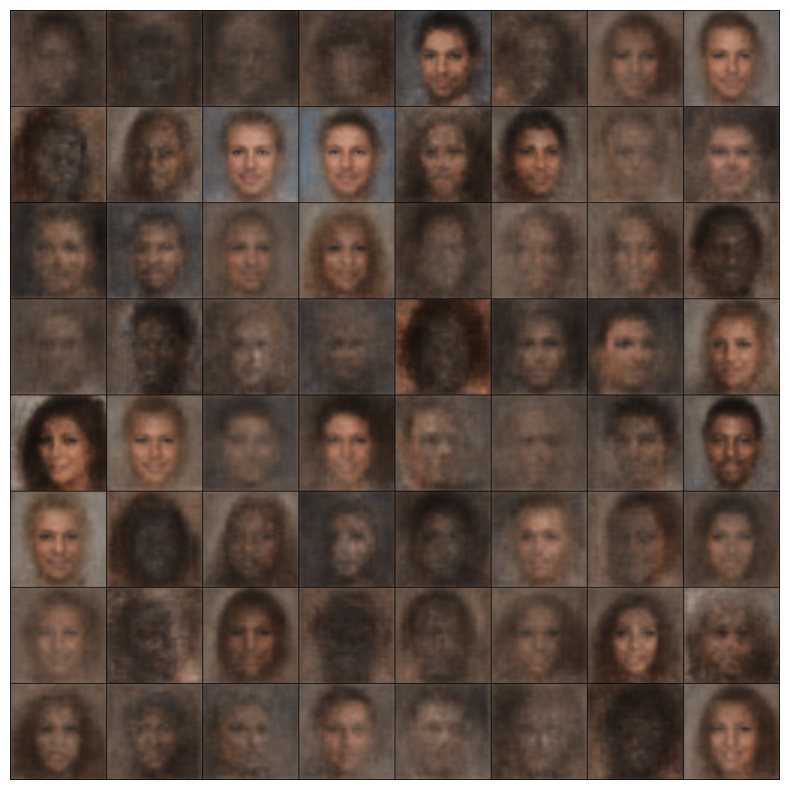

In [85]:
model.eval()
with torch.no_grad():
    sample = torch.randn(64, latent_dim).to(device)
    sample = model.decode(sample).cpu()
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(make_grid(sample.view(64, 3, 256, 256)).permute(1, 2, 0))
    ax.axis('off')
    plt.show()